In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array

from keras.applications.mobilenet_v2 import preprocess_input

from keras import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model


2023-09-28 23:16:33.464294: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
target_img_size = (220, 220)
input_size = (220, 10, 3)

**Read the picture from folder**

In [3]:
train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    '/Users/top/poorject/Soil types',
    target_size = (200, 200),
    batch_size = 32,
    classes = [ 'Black Soil','Cinder Soil', 'Laterite Soil','Peat Soil','Yellow Soil'],
    class_mode='categorical'
    )

Found 1171 images belonging to 5 classes.


In [4]:
print (train_generator.class_indices)
ids, count = np.unique(train_generator.classes, return_counts=True)

print(ids)
print(count)

{'Black Soil': 0, 'Cinder Soil': 1, 'Laterite Soil': 2, 'Peat Soil': 3, 'Yellow Soil': 4}
[0 1 2 3 4]
[265 555 292  30  29]


In [5]:
for image_batch, label_batch in train_generator :
    break
    image_batch.shape, label_batch.shape

In [6]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

for i in ids:
    print('{:>8} = {}' . format(labels[i], count[i]))

Black Soil = 265
Cinder Soil = 555
Laterite Soil = 292
Peat Soil = 30
Yellow Soil = 29


In [7]:
label_names = [k for k in train_generator.class_indices]
label_names


['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil']

In [8]:
import pandas as pd

df = pd.DataFrame({"Label":label_names, "Count":count})
df.set_index("Label", inplace=True)
df


,Count
Label,
Black Soil,265
Cinder Soil,555
Laterite Soil,292
Peat Soil,30
Yellow Soil,29


**Create Neural Network**

In [9]:
model =Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(220, 220, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 109, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 51, 51, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 25, 25, 64)        0

In [11]:
total_sample = train_generator.n
n_epochs = 30

In [12]:
model.compile(loss="categorical_crossentropy",
                optimizer='adam',
                metrics=['acc'])

es = EarlyStopping(monitor="val_loss",
                   verbose=1,
                   patience=3)

mc = ModelCheckpoint("best_model.h5", 
                    monitor="val_accuracy", 
                    verbose=1, 
                    save_best_only=True)

start = time.time()

history = model.fit(train_generator,
                    steps_per_epoch = int(total_sample/32),
                    epochs=n_epochs,
                    verbose=1, callbacks=[es, mc])

end = time.time()
print("Time taken: {:.2f} minutes".format((end - start) / 60))

Epoch 1/30
36/36 [==============================] - 20s 484ms/step - loss: 1.2196 - acc: 0.4460
Epoch 2/30
36/36 [==============================] - 18s 491ms/step - loss: 0.7865 - acc: 0.7234
Epoch 3/30
36/36 [==============================] - 17s 469ms/step - loss: 0.4274 - acc: 0.8648
Epoch 4/30
36/36 [==============================] - 17s 475ms/step - loss: 0.3592 - acc: 0.8824
Epoch 5/30
36/36 [==============================] - 17s 476ms/step - loss: 0.2994 - acc: 0.8955
Epoch 6/30
36/36 [==============================] - 18s 475ms/step - loss: 0.2599 - acc: 0.9122
Epoch 7/30
36/36 [==============================] - 18s 482ms/step - loss: 0.2504 - acc: 0.9052
Epoch 8/30
36/36 [==============================] - 18s 483ms/step - loss: 0.2301 - acc: 0.9210
Epoch 9/30
36/36 [==============================] - 17s 471ms/step - loss: 0.2851 - acc: 0.9008
Epoch 10/30
36/36 [==============================] - 17s 472ms/step - loss: 0.2668 - acc: 0.9140
Epoch 11/30
36/36 [====================

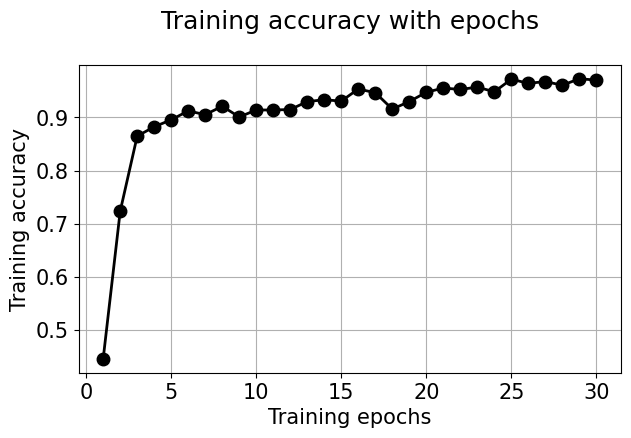

In [13]:
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(n_epochs)],history.history['acc'],'-o',c='k',lw=2,markersize=9)
plt.grid(True)
plt.title("Training accuracy with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training accuracy",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [14]:
def predict(img_fname):
    img = load_img(img_fname, target_size=target_img_size)
    plt.imshow(img)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    pred = model.predict(img)
    pred_cls = labels[np.argmax(pred, -1)[0]]
    print("Prediction:", pred_cls, pred[0].round(3))
    return(pred_cls, pred)



In [15]:
labels = (train_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())
labels

{0: 'Black Soil',
 1: 'Cinder Soil',
 2: 'Laterite Soil',
 3: 'Peat Soil',
 4: 'Yellow Soil'}

1/1 [==============================] - 0s 325ms/step
Prediction: Yellow Soil [0. 0. 0. 0. 1.]


'Yellow Soil'

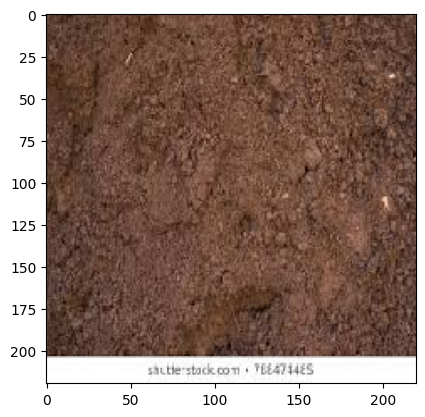

In [16]:
_,pred_result = predict('Soil types/test/soil_1.jpg')
labels[np.argmax(pred_result, -1)[0]]

**Save model in .h5 for use**

In [17]:
model.save('model_saved/trained_pic_classify_model.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Save model in folder for use**

In [18]:
model.save("model_saved/my_pic_classify_model")

INFO:tensorflow:Assets written to: model_saved/my_pic_classify_model/assets


INFO:tensorflow:Assets written to: model_saved/my_pic_classify_model/assets


In [19]:
import pickle

file_name = "model_saved/my_pic_classify_model.pkl"
open_file = open(file_name, "wb")
pickle.dump(labels, open_file)
open_file.close()

**Load .h5 for use**

In [20]:
my_model = load_model("model_saved/trained_pic_classify_model.h5")

In [21]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 109, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 51, 51, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 25, 25, 64)        0

In [22]:
file_name = "model_saved/my_pic_classify_model.pkl"
open_file = open(file_name, "rb")
class_name = pickle.load(open_file)
open_file.close()

class_name

{0: 'Black Soil',
 1: 'Cinder Soil',
 2: 'Laterite Soil',
 3: 'Peat Soil',
 4: 'Yellow Soil'}

**Using.h5 model to predict**

1/1 [==============================] - 0s 153ms/step
[[0.0000000e+00 1.0395318e-06 5.0821536e-15 1.1355075e-34 9.9999893e-01]]


'Yellow Soil'

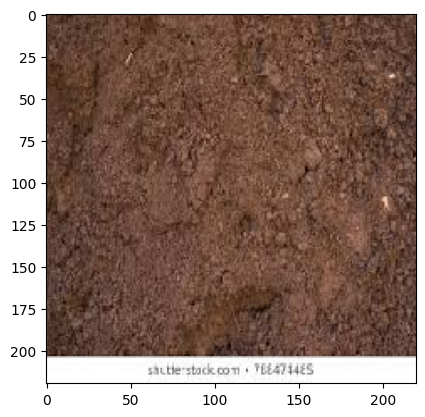

In [23]:
input_image = "Soil types/test/soil_1.jpg"
img = image.load_img(input_image, target_size=(220, 220))

pred_img = image.img_to_array(img)
pred_img = np.expand_dims(pred_img, axis=0)
pred_img = preprocess_input(pred_img)
plt.imshow(img)

my_model = load_model("model_saved/trained_pic_classify_model.h5")
pred_result = my_model.predict(pred_img)
print(pred_result)
class_name[np.argmax(pred_result, -1)[0]]

**Convert .h5 to TensorflowLite**

In [24]:
model = load_model("model_saved/trained_pic_classify_model.h5/")

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

f = open("trained_pic_classify_model.tflite", "wb")
f.write(tflite_model)
f.close()

regular_model_size = len(tflite_model) / 1024 
print("Regular model size = %d KBs." % regular_model_size)       

INFO:tensorflow:Assets written to: /var/folders/nv/xbhq_4nd7q7fytcch4y0ylzh0000gr/T/tmpyvtinziy/assets


INFO:tensorflow:Assets written to: /var/folders/nv/xbhq_4nd7q7fytcch4y0ylzh0000gr/T/tmpyvtinziy/assets


Regular model size = 901 KBs.


2023-09-28 23:26:07.430522: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-09-28 23:26:07.430853: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-09-28 23:26:07.432090: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/nv/xbhq_4nd7q7fytcch4y0ylzh0000gr/T/tmpyvtinziy
2023-09-28 23:26:07.435504: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-09-28 23:26:07.435527: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/nv/xbhq_4nd7q7fytcch4y0ylzh0000gr/T/tmpyvtinziy
2023-09-28 23:26:07.445281: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-09-28 23:26:07.448837: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-09-28 23:26:07.599445: I tensorflow/cc/saved_model/loader.

In [26]:
tflite_path = "model_saved/trained_pic_classify_model.tflite"

interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input = interpreter.get_input_details()
input_size = input[0]['shape']
print("Input shape:", input_size)

input_tf_index = input[0]["index"]
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

interpreter.set_tensor(input_tf_index, pred_img)

start = time.time()
interpreter.invoke()
end = time.time()

total_time = end - start
print("Total prediction time:", total_time)

digit = np.argmax(output()[0])
print(class_name[digit])

Input shape: [  1 220 220   3]
Total prediction time: 0.018329858779907227
Laterite Soil


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
